In [15]:
# Importing the Libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # visualizations
import seaborn as sns # visualizations
import math # use math operators
import sqlalchemy as sq # use of sql commands
import plotly.express as px # interactive graphs
import plotly.graph_objects as go # interactive graphs
from plotly.subplots import make_subplots # interactive graphs
import datetime as dt # manipulating date objects
from scipy.stats import pearsonr # fundamentals algorithms
import math # use math operators
import plotly.express as px # interacting graphing and visualization
import warnings # deal with warnings
import pandasql as ps

In [ ]:
 
Guiding Question 3. Which factors of a country's population are most related to the severity and prevalence of COVID-19?

In order to solve this question, we are going to define severity of covid as the total number of deaths a country has had due to covid, and prevalance as the amount of Covid-19 cases a country 
has had.

The variables in our data that describe our population are inclusive of number of vaccinated people, number of booster received, total hospitalized patients, median age, poverty rates, ratio of smokers, how prevalent is diabetes, raw number of the population, how dense is the population, and what is the average life expectancy.

To solve this question, what we are trying to achieve is to find the regression coefficient for as many variables as possible wether or not they are significant or not in predicting the number of cases in a country, by doing this we will receive an estimate of how each variable contributed to the number of cases and deaths a specific country has had.

We will first plot our variables in a correlation matrix to eliminate highly correlated variables, split the data into training and testing, and then create a model for prediction for both number of cases and number of deaths a country has had during the pandemic to determine the impact of each variable.

In [2]:
# Importing the COVID-19 dataset for G20 countries, which was previously cleaned:
covid_data = pd.read_csv("C:\\Users\\joshu\\Documents\\604\Datasets\\Clean\\g20_covid.csv")
covid_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,ARG,South America,Argentina,2020-01-01 0:00,0,0,0.0,0,0,0.0,...,27.7,0.0,5.0,76.67,0.845,45276780,0.0,0.0,0.0,0.0
1,ARG,South America,Argentina,2020-01-02 0:00,0,0,0.0,0,0,0.0,...,27.7,0.0,5.0,76.67,0.845,45276780,0.0,0.0,0.0,0.0
2,ARG,South America,Argentina,2020-01-03 0:00,0,0,0.0,0,0,0.0,...,27.7,0.0,5.0,76.67,0.845,45276780,0.0,0.0,0.0,0.0
3,ARG,South America,Argentina,2020-01-04 0:00,0,0,0.0,0,0,0.0,...,27.7,0.0,5.0,76.67,0.845,45276780,0.0,0.0,0.0,0.0
4,ARG,South America,Argentina,2020-01-05 0:00,0,0,0.0,0,0,0.0,...,27.7,0.0,5.0,76.67,0.845,45276780,0.0,0.0,0.0,0.0


In [21]:
DataFrame = ps.sqldf('''   
               select location,
               sum(new_cases) as cases,
               max(total_deaths) as deaths,
               max(total_vaccinations) as total_vaccinations,
               max(total_boosters) as total_boosters,
               sum(hosp_patients) as total_patients,
               median_age,
               extreme_poverty,
               male_smokers,
               female_smokers,
               male_smokers + female_smokers as total_smokers,
               diabetes_prevalence,
               population,
               population_density,
               life_expectancy
                                            
                                            
               from covid_data
               group by location, median_age, extreme_poverty, male_smokers, female_smokers
                                                
                                    ''')

In [23]:
Cases = pd.DataFrame(DataFrame, columns = ['location', 'cases', 'deaths', 'total_vaccinations', 'total_boosters', 'total_patients', 'median_age', 'extreme_poverty', 'female_smokers' , 'male_smokers', 'total_smokers', 'diabetes_prevalence', 'population', 'population_density', 'life_expectancy'])

Deaths = pd.DataFrame(DataFrame, columns = ['location', 'cases', 'deaths', 'total_vaccinations', 'total_boosters', 'total_patients', 'median_age', 'extreme_poverty', 'male_smokers', 'female_smokers', 'total_smokers', 'diabetes_prevalence', 'population', 'population_density', 'life_expectancy'])

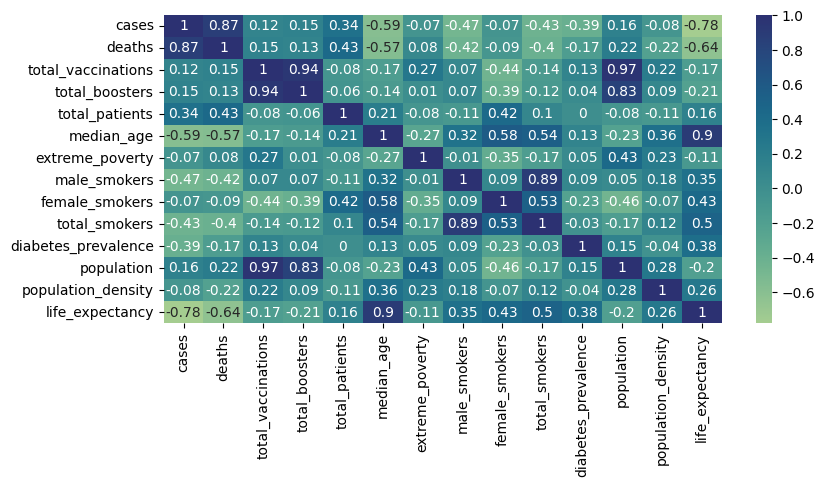

In [25]:
# To obtain an overview of the extent to which each of the numerical variables in our 
# dataset are related to housing prices, we used a heat map to present each of these correlations
f, ax = plt.subplots(figsize=(9, 4))
sns.heatmap(round(DataFrame.drop(['location'], axis=1).corr(),2), annot=True, cmap='crest')
plt.show()

In [ ]:
Why we chose to keep or remove columns:

The first step we did in order to solve this question was to plot all variables on a correlation matrix to see which variables were highly correlated with one another.
The reason we do this is because the regression coefficient is defined as the change in the dependent variable for each 1 unit change in an independent variable when you hold all of the other independent variables constant. It is difficult to hold all other variables constant when there is high correlation between variables so in order for our analysis to product somewhat trustworthy results, we need to choose only 1 of the group of variables that are highly correlated with each other. In order to keep as much variables as possible, we will define high correlation as a correlation value of higher than .60.

From the correlation matrix we saw that population, total boosters, and total vaccincations were all highly correlated to each other. From there we decided to 
eliminate total boosters and total vaccincations as population was the highest correlated to our response variables, total cases and total deaths.
We followed the same procedure for median age and life expectancy resulting in the removal of the median age variable, and lastly on total smokers with female and male smokers 
resulting in the removal of the combined ratio 'total smokers', due to the variable 'male smokers' being more correlated with our response variables than the combined ratio variable.

Our remaining variables are now extreme poverty, female smokers, male smokers, diabetes prevalence, population, population density, and life expectancy.


In [47]:
# Selecting the variables we will use for the Linear Regression Model.
# Based on the heat map, we decided to use the variables that have the highest correlation with Price.
# We checked for overfitting by not including independent variables that were highly correlated with one another.
regression_columns = ['extreme_poverty', 'female_smokers', 'male_smokers' , 'diabetes_prevalence', 'population', 'population_density', 'life_expectancy', 'cases']
df_reg = DataFrame[regression_columns]

# Price is our dependent variable. We created a new data frame for that variable named 'y'
y = df_reg.iloc[:,-1]
# We created a data frame for our independent variables and called this 'x'
x = df_reg.iloc[:,:-1]
#y.head(10)
#x.head(10)

In [48]:
# Splitting the data into training and testing 
from sklearn.model_selection import train_test_split

# Fixing the random assignment for testing and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)
print(y_train)

# Creating the Linear Regression Model
from sklearn.linear_model import LinearRegression # Linear Regression Class

lrm = LinearRegression()
lrm.fit(x_train, y_train)

4       1023217
16     25431104
6      37223397
7      35461979
15      4008200
12      7109227
9       6478720
11     22135124
19     97343425
18     23019314
13     21089873
5     174035754
0       9717546
8      44647039
3       4369567
10     23443577
Name: cases, dtype: int64


LinearRegression()

In [49]:
# Predicting using x_test
y_pred = lrm.predict(x_test)
print(y_pred)
# Comparing y_test and y_pred
y_comparison = pd.DataFrame({'y_pred': np.round(y_pred, 2), 'y_test': np.round(y_test, 2)})
y_comparison['residuals'] = y_comparison['y_test'] - y_comparison['y_pred']
y_comparison.head(20)

[34391532.60032579 19073244.79345736 -2407263.80945569 34977616.44044968]


,y_pred,y_test,residuals
14,34391532.60,821246,-33570286.60
2,19073244.79,34702129,15628884.21
1,-2407263.81,10377718,12784981.81
17,34977616.44,16096413,-18881203.44


In [50]:
# Checking cross validation and the R^2 value of our model
from sklearn.model_selection import cross_val_score # Cross Validation 

cv = cross_val_score(lrm, x_train, y_train, cv=2) # R-squared: proportion of the variance for a DV explained by a IVs in a regression model
cv.mean()

-77.09927073078508

In [51]:
# Printing the coefficients and y-intercept for our model [cases]
print(lrm.coef_)
print(lrm.intercept_)

regression_columns = ['extreme_poverty', 'female_smokers', 'male_smokers' , 'diabetes_prevalence', 'population', 'population_density', 'life_expectancy', 'cases']

[-1.28105140e+06  1.99068670e+06 -4.16204192e+05  3.21810249e+06
  8.00708495e-03  7.57824515e+04 -2.46093787e+06]
167796372.38727686


In [ ]:
Cases Conclusion:

Our model for predicting Total Cases show that for every 1 unit increase in female smokers, diabetes prevalence, poulation, and population density, total covid cases for each country
increase by 1.990686.70, 3218102.49, 8007.08, and 75782.45 cases respectively.

It also shows that for every 1 unit increase in extreme poverty index, male smokers, and life expectancy, total covid cases for each country decrease by 1281051.40, 4162041.92, and 2460937.87 cases respectively.

Now a few things to note that this model is limited to the information provided by the dataset which could to an extent, be potentially flawed. This can be shown through the poverty index in which it interprets that countries deem to be in 'extreme poverty' have less cases than those with a lower extreme poverty value, as well as where it says that as male smokers increase covid cases decrease, but when female smokers increase, covid cases increase.

With regards to these limitations, however, we can have an estimate of how each variable contributed to the amount of total covid cases each country has had by looking at the coefficient regression of each variable.

In [39]:
# Selecting the variables we will use for the Linear Regression Model.
# Based on the heat map, we decided to use the variables that have the highest correlation with Price.
# We checked for overfitting by not including independent variables that were highly correlated with one another.
regression_columns2 = ['extreme_poverty', 'female_smokers', 'male_smokers' , 'diabetes_prevalence', 'population', 'population_density', 'life_expectancy', 'deaths']
df_reg2 = DataFrame[regression_columns2]

# Price is our dependent variable. We created a new data frame for that variable named 'y'
y = df_reg2.iloc[:,-1]
# We created a data frame for our independent variables and called this 'x'
x = df_reg2.iloc[:,:-1]
#y.head(10)
#x.head(10)

In [40]:
# Splitting the data into training and testing 
from sklearn.model_selection import train_test_split

# Fixing the random assignment for testing and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)
print(y_train)

# Creating the Linear Regression Model
from sklearn.linear_model import LinearRegression # Linear Regression Class

lrm = LinearRegression()
lrm.fit(x_train, y_train)

4        5226
16      29069
6      156769
7      153193
15     102257
12     330353
9      158499
11      46520
19    1069449
18     208497
13     381920
5     1159928
0      129979
8      528987
3       46406
10     178846
Name: deaths, dtype: int64


LinearRegression()

In [41]:
# Predicting using x_test
y_pred = lrm.predict(x_test)
print(y_pred)
# Comparing y_test and y_pred
y_comparison = pd.DataFrame({'y_pred': np.round(y_pred, 2), 'y_test': np.round(y_test, 2)})
y_comparison['residuals'] = y_comparison['y_test'] - y_comparison['y_pred']
y_comparison.head(20)

[691794.70007316 261703.02080654 -19485.97795125 499444.17549333]


,y_pred,y_test,residuals
14,691794.70,9400,-682394.70
2,261703.02,687907,426203.98
1,-19485.98,15589,35074.98
17,499444.18,101203,-398241.18


In [42]:
# Checking cross validation and the R^2 value of our model
from sklearn.model_selection import cross_val_score # Cross Validation 

cv = cross_val_score(lrm, x_train, y_train, cv=2) # R-squared: proportion of the variance for a DV explained by a IVs in a regression model
cv.mean()

-47.84940195648671

In [43]:
# Printing the coefficients and y-intercept for our model [deaths]
print(lrm.coef_)
print(lrm.intercept_)

regression_columns2 = ['extreme_poverty', 'female_smokers', 'male_smokers' , 'diabetes_prevalence', 'population', 'population_density', 'life_expectancy', 'deaths']

[-2.15467296e+03  1.65557793e+04 -2.05068302e+03  5.91761914e+04
  3.41459418e-05  1.77712289e+02 -1.95913351e+04]
1133426.0683337552


In [ ]:
Deaths Conclusion:

Our model for predicting Total Deaths show that for every 1 unit increase in female smokers, diabetes prevalence, poulation, and population density, total covid deaths for each country
increase by 16555.77, 59176.19, 341459.41, and 177.71 deaths respectively.

It also shows that for every 1 unit increase in extreme poverty index, male smokers, and life expectancy, total covid deaths for each country decrease by 2154.67, 2050.68, and 19591.33 deaths respectively.

Now a few things to note that similar to the model predicting total cases, this model is also limited to the information provided by the dataset which could to an extent, be potentially flawed. This can be shown through the poverty index in which it interprets that countries deem to be in 'extreme poverty' have less cases than those with a lower extreme poverty value, as well as where it says that as male smokers increase covid cases decrease, but when female smokers increase, covid cases increase.

With regards to these limitations, however, we can have an estimate of how each variable contributed to the amount of total covid deaths each country has had by looking at the coefficient regression of each variable.